In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import pickle as pkl
from dateutil import parser
from datetime import datetime
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import Levenshtein
from wordcloud import STOPWORDS
from unidecode import unidecode
import unicodedata
from omnibelt import load_json, save_json

In [2]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [3]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		if desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))
def str_similarity(string1: str, string2: str):
	distance = Levenshtein.distance(string1, string2)
	similarity = 1 - (distance / max(len(string1), len(string2)))
	return similarity
def capsim(s1, s2):
	s1, s2 = unidecode(s1), unidecode(s2)
	return (str_similarity(s1.lower(), s2.lower()) + str_similarity(s1, s2)) / 2
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
stop_words = set(STOPWORDS)
def is_good_word(w):
	return not all(unicodedata.category(char).startswith('P') or unicodedata.category(char).startswith('N') for char in w) and w not in stop_words

In [5]:
root = Path('/home/fleeb/workspace/local_data/nnn')
# root = Path(r'C:\Users\anwan\Documents\workspace\nnn')
recs = (root / 'old-bb-v1').glob('**/*.json')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
temproot = root/'temp'
temproot.mkdir(exist_ok=True)
recs = list(recs)
len(recs)

54

In [6]:
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [7]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [8]:
batch = by_lang['de']
len(batch)

259718

In [9]:
art = random.choice(batch)
view_article(art, detailed=True)
print(art['source-name'])

English Title: 'Mead Drinks Market 2021 to reflect significant growth in future with analysis of size, share, growth and key companies – jazznews - Jazz News'
German Title: 'Met-Getränke Market 2021 wird ein signifikantes Wachstum in der Zukunft mit einer Analyse von Größe, Anteil, Wachstum und Schlüsselunternehmen widerspiegeln – jazznews - Jazz News'
Categories: <business>  ---   'Austria' (08 Aug21)  ---  Jazz-news.at
- No description -
Jazz-news.at


In [10]:
# lowercase_all = True
# full_bagowords_inds = {int(ID): {k.lower() if lowercase_all else k:v for k,v in bag.items()} 
# 					   for ID, bag in tqdm(load_json(root/'bagowords-ordered-full.json').items())}
# 
# pre_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items()):
# 	if '-' in bagi:
# 		pre_dash.update({w: len(inds) for w, inds in bagi.items() if all(i < bagi["-"][-1] for i in inds)})
# 
# post_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items()):
# 	if '-' in bagi:
# 		post_dash.update({w: len(inds) for w, inds in bagi.items() if w not in pre_dash})
# all_bags_inds = {ID: {w: [i for i in inds if bag.get('-', [float('inf')])[-1] > i]
# 					  for w, inds in bag.items() if w not in post_dash and is_good_word(w)}
# 				 for ID, bag in tqdm(full_bagowords_inds.items())}
# all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds)}) for ID, bag in all_bags_inds.items()}
# len(all_bags)
# save_json(all_bags, temproot/'all_bags.json')
# save_json(all_bags_inds, temproot/'all_bags_inds.json')
# all_bags_inds = pkl.load(open(root/'temp'/'all_bags_inds.pkl', 'rb'))
# all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds) and is_good_word(w)}) for ID, bag in all_bags_inds.items()}
# world = articles
# df = pd.DataFrame(
# 	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in world]) for i, inst in
# 	 enumerate(by_ID[row['aid']]['instances'])])
# df['collectedAt'] = pd.to_datetime(df['collectedAt'])
# df = df.sort_values('collectedAt')
# df['date'] = df['collectedAt'].dt.date
# len(df)
# 
# daybags = {}
# date_aids = dict(df.groupby('date')['aid'].apply(set))
# for date, aIDs in tqdm(sorted(date_aids.items())):
# 	total = Counter()
# 	for aID in aIDs:
# 		total.update(all_bags[aID])
# 	daybags[date] = total
# len(daybags)
# dayidf = Counter()
# for date, bag in tqdm(daybags.items()):
# 	dayidf.update(bag.keys())
# dayidf = {w: np.log(len(daybags) / f) for w, f in dayidf.items()}
# daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
# daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in
# 			tqdm(daybags.items())}
# len(daytfidf)

In [11]:
use_bags_as_sets = True
all_bags = load_json(temproot/'all_bags.json')
# all_bags_inds = load_json(temproot/'all_bags_inds.json')
all_bags = {int(ID): set(bag) if use_bags_as_sets else bag for ID, bag in all_bags.items()}
# pkl.dump(date_aids, open(temproot/'date_aids.pkl', 'wb'))
date_aids = pkl.load(open(temproot/'date_aids.pkl', 'rb'))
daytfidf = pkl.load(open(temproot/'daytfidf.pkl', 'rb'))
daybags = {}
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags), len(all_bags)#, len(all_bags_inds)

  0%|          | 0/413 [00:00<?, ?it/s]

(413, 4719199)

In [94]:
def cluster_min_agreement(bag, aids, match_req=.5):
	total = sum(bag.values())
	matches, remaining = [], []
	if total > 0:
		for aid in aids:
			(matches if sum(bag.get(w,0) for w in all_bags[aid]) / total >= match_req else remaining).append(aid)
			# (matches if len(bag & all_bags[aid]) >= max(1, min(len(bag), len(all_bags[aid]), match_req)) else remaining).append(aid)
	return matches, remaining

def date_freq(today, topk=5, daterange=None, before=20, after=20, match_req=.5, pbar=False):
	if daterange is None:
		mindate = today - pd.Timedelta(days=before)
		maxdate = today + pd.Timedelta(days=after)
		daterange = [d for d in daytfidf if mindate <= d <= maxdate]
	deltas = [(d - today).days for d in daterange]
	importances = daytfidf[today]
	scores = Counter({aid: sum(importances.get(w, 0) for w in all_bags[aid]) for aid in date_aids[today]})
	
	keydocs = {}
	
	todo = list(date_aids[today])
	for k in tqdm(range(topk)) if pbar else range(topk):
		center = max(todo, key=lambda aid: scores[aid])
		# print(center, ', '.join(f'{w!r}' for w in sorted(all_bags[center], key=lambda w: importances.get(w,0), reverse=True)[:8]))
		cluster = {w: importances[w] for w in all_bags[center]}
		todo.remove(center)
		matches = {}
		for i in range(len(deltas)):
			delta = deltas[i]
			matches[delta], other = cluster_min_agreement(cluster, todo if delta == 0 else date_aids[daterange[i]], match_req=match_req)
			if delta == 0:
				todo = other
				matches[delta].append(center)
		keydocs[center] = matches
	return keydocs

In [13]:
start, end = datetime(2020, 10, 3).date(), datetime(2021, 10, 3).date()
lowlimit, highlimit = min(daytfidf), max(daytfidf)
start in daytfidf, end in daytfidf

(True, True)

In [28]:
target = random.choice(list(daytfidf.keys()))
target = random.choice([d for d in daytfidf if start <= d <= end])
target = datetime(2021, 2, 1).date()
# target = datetime(2021, 1, 8).date()
importances = daytfidf[target]
counts = daybags[target]
def compute_article_score(aid):
	return sum(importances.get(w, 0) for w in all_bags[aid])
scores = Counter({aid: compute_article_score(aid) for aid in date_aids[target]})
print(target.strftime('%d %b %Y'))
offset = (target - start).days
offset = 0
# offset

01 Feb 2021


In [29]:
top = {}
todo = list(scores.keys())
intial_num = len(todo)
# day_delta = 40
day_before = 30
day_after = 30

topk = 10
match_threshold = 0.25

In [30]:
for _ in range(10):
	center = max(todo, key=lambda aid: scores[aid])
	cluster = {w: importances[w] for w in all_bags[center]}
	todo.remove(center)
	matches, todo = cluster_min_agreement(cluster, todo, match_req=match_threshold)
	top[center] = matches
# len(matches), len(todo)
print(tabulate([(
	aid, 
	# scores[aid], 
	len(matches), 
	', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8]) + (f' + {len(all_bags[aid])-8} more' if len(all_bags[aid]) > 8 else ''), 
	# len(all_bags[aid])
) for aid, matches in sorted(top.items(), key=lambda item: scores[item[0]], reverse=True)]))
print(f'{intial_num-len(todo)} / {intial_num}   ---   {(intial_num-len(todo))/intial_num:.2%} for {len(top)} clusters')

-------  --  ---------------------------------------------------------------------------------------------------------------------
2906997  20  'suu', 'kyi', 'aung', 'myanmar', "d'etat", 'coup', 'detain', 'san' + 4 more
2908689  86  'gamestop', 'reddit', 'winklevoss', 'mgm', 'coindesk', 'twins', 'investor', 'movie' + 5 more
2911138   8  'caleta', 'duje', 'davies', 'preston', 'liverpool', 'marseille', 'ben', 'transfer' + 7 more
2909032   0  'cyden', 'silkaeur(tm)n', 'cosbeauty', 'smoothskin', 'iluminage', 'soccernurds', 'remington', 'competitors' + 18 more
2908399   5  'asos', 'topshop', 'selfridge', 'ps330', 'm', 'brand', 'miss', 'buy'
2909529   6  'wilmore', 'simpsons', 'screenwriter', 'marc', 'die'
2908550   1  'daikoku', 'masao', 'kurihara', 'masashi', 'mos', 'burgers', 'gamba', 'coach' + 12 more
2910467   0  'pagale', 'shusteri', 'puku', 'dzenu', 'lipke', 'badge', 'silver', 'memorial' + 5 more
2906137   7  'garmisch', 'goggia', 'dominator', 'downhill', 'home', 'world', 'cup', 'fall

In [31]:
grand, matches = max(top.items(), key=lambda item: scores[item[0]])
print(tabulate([[i, aid, ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8]) + (f' + {len(all_bags[aid])-8} more' if len(all_bags[aid]) > 8 else '')]
				for i, aid in enumerate(matches)]))

--  -------  --------------------------------------------------------------------------------------------------------
 0  2906440  'suu', 'kyi', 'aung', 'myanmar', 'san', 'army', 'bar', 'street' + 1 more
 1  2907065  'aung', 'myanmar|the', 'career|apple', 'acquiescence', 'coup', 'suspected', 'intervene', 'san' + 14 more
 2  2907304  'suu', 'kyi', 'aung', 'myanmar', 'coup', 'detain', 'san', 'military' + 5 more
 3  2907695  'suu', 'kyi', 'aung', 'myanmar', 'coup', 'detain', 'san', 'military' + 1 more
 4  2907976  'suu', 'kyi', 'aung', 'myanmar', 'coup', 'san', 'army', 'arrest' + 3 more
 5  2908083  'suu', 'kyi', 'aung', 'myanmar', 'coup', 'detain', 'san', 'military' + 5 more
 6  2908218  'suu', 'kyi', 'aung', 'burmese', 'wilmes', 'sophie', 'michel', 'san' + 5 more
 7  2908388  'suu', 'kyi', 'aung', 'myanmar', 'putsch', 'pravda', 'san', 'country' + 1 more
 8  2908506  'suu', 'kyi', 'aung', 'myanmar', 'coup', 'detain', 'san', 'military' + 2 more
 9  2909178  'suu', 'kyi', 'aung', 'myanmar'

In [32]:
keydocs = date_freq(target, topk=topk, before=day_before, after=day_after, match_req=match_threshold)
print(tabulate([(
	len(all_bags[aid]), 
	aid,
				 sum(len(m) for d, m in matches.items() if d < 0), 
				 sum(len(m) for d, m in matches.items() if d == 0), 
				 sum(len(m) for d, m in matches.items() if d > 0), 
				 ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8])
				 ) for aid, matches in keydocs.items()]))
len(keydocs)

  0%|          | 0/10 [00:00<?, ?it/s]

--  -------  ---  --  ---  -----------------------------------------------------------------------------------------------------------
12  2906997    2  21   84  'suu', 'kyi', 'aung', 'myanmar', "d'etat", 'coup', 'detain', 'san'
13  2908689  398  87  778  'gamestop', 'reddit', 'winklevoss', 'mgm', 'coindesk', 'twins', 'investor', 'movie'
15  2911138    1   9    6  'caleta', 'duje', 'davies', 'preston', 'liverpool', 'marseille', 'ben', 'transfer'
26  2909032    0   1    0  'cyden', 'silkaeur(tm)n', 'cosbeauty', 'smoothskin', 'iluminage', 'soccernurds', 'remington', 'competitors'
 8  2908399   19   6   16  'asos', 'topshop', 'selfridge', 'ps330', 'm', 'brand', 'miss', 'buy'
 5  2909529    0   7    8  'wilmore', 'simpsons', 'screenwriter', 'marc', 'die'
20  2908550    0   2    3  'daikoku', 'masao', 'kurihara', 'masashi', 'mos', 'burgers', 'gamba', 'coach'
13  2910467    0   1    0  'pagale', 'shusteri', 'puku', 'dzenu', 'lipke', 'badge', 'silver', 'memorial'
 9  2906137   41   8   22  'g

10

In [33]:
best = {center: matches for center, matches in keydocs.items() if len(matches[0]) == max(map(len,matches.values()))}
print(tabulate([(
	len(all_bags[aid]), 
	aid,
				 sum(len(m) for d, m in matches.items() if d < 0), 
				 sum(len(m) for d, m in matches.items() if d == 0), 
				 sum(len(m) for d, m in matches.items() if d > 0), 
				 ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8])
				 ) for aid, matches in best.items()]))

--  -------  --  --  --  -----------------------------------------------------------------------------------------------------------
12  2906997   2  21  84  'suu', 'kyi', 'aung', 'myanmar', "d'etat", 'coup', 'detain', 'san'
15  2911138   1   9   6  'caleta', 'duje', 'davies', 'preston', 'liverpool', 'marseille', 'ben', 'transfer'
26  2909032   0   1   0  'cyden', 'silkaeur(tm)n', 'cosbeauty', 'smoothskin', 'iluminage', 'soccernurds', 'remington', 'competitors'
 8  2908399  19   6  16  'asos', 'topshop', 'selfridge', 'ps330', 'm', 'brand', 'miss', 'buy'
20  2908550   0   2   3  'daikoku', 'masao', 'kurihara', 'masashi', 'mos', 'burgers', 'gamba', 'coach'
13  2910467   0   1   0  'pagale', 'shusteri', 'puku', 'dzenu', 'lipke', 'badge', 'silver', 'memorial'
 9  2906137  41   8  22  'garmisch', 'goggia', 'dominator', 'downhill', 'home', 'world', 'cup', 'fall'
19  2911303   1   2   1  'vegfr', 'rate-', 'vegf', 'mundo', 'novartis', 'glaxosmithkline', 'ciruja', 'plc'
--  -------  --  --  -- 

In [40]:
X = np.arange(-day_before, day_after+1)
Ys = []
IDs = []
for center, matches in sorted(best.items(), key=lambda item: sum(map(len,item[1].values())), reverse=False):
	IDs.append(center)
	x, y = zip(*[(d+offset, len(m)) for d, m in matches.items()])
	interp_func = interp1d(x, y, kind='linear', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T
X += offset
X.shape, Ys.shape

((61,), (61, 8))

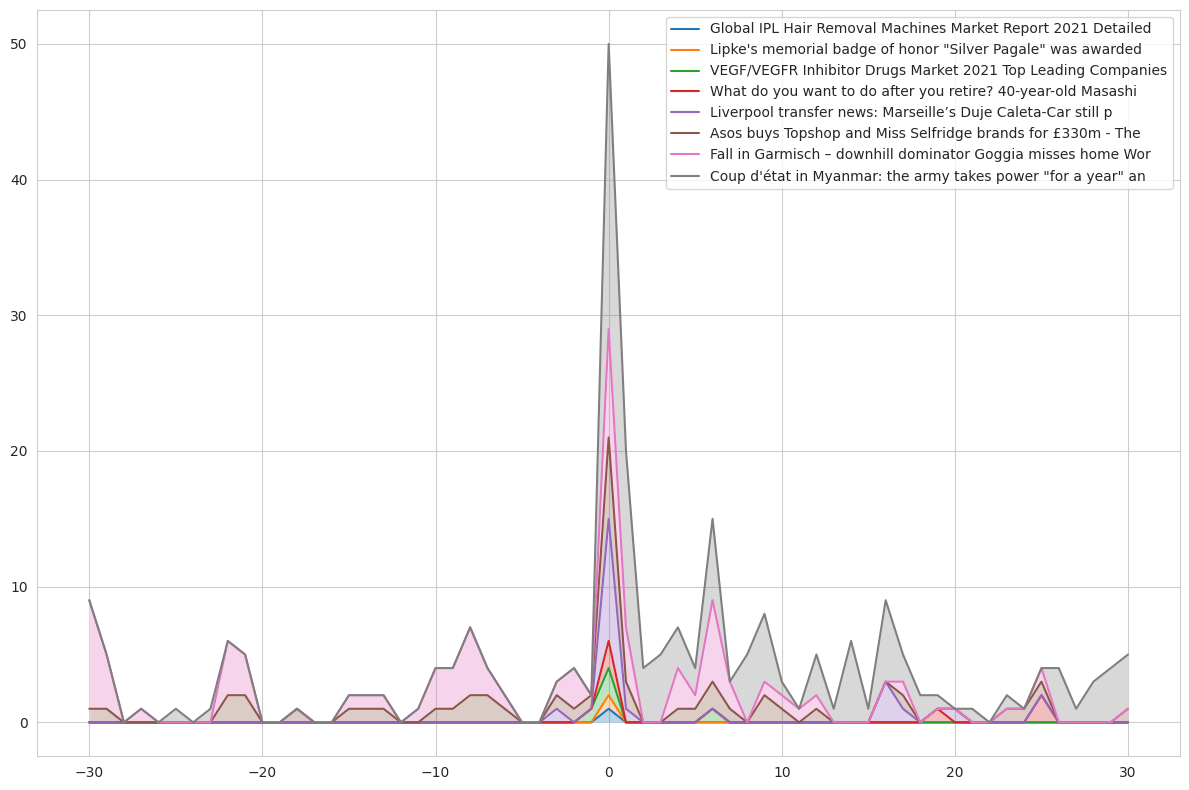

In [41]:
plt.figure(figsize=(12,8))

cYs = Ys.cumsum(-1)

Y = cYs
# Y = Ys

plt.plot(X, Y, label=[by_ID[aid].get('en-title', by_ID[aid]['title'])[:60] for aid in IDs])

lb = 0
for i in range(Y.shape[1]):
	plt.fill_between(X, lb, Y[:, i], alpha=.3)
	lb = Y[:, i]

plt.legend();
# plt.ylim(0, 400);
# plt.xlim(0, 300);
# plt.plot(X, Ys, label=f'{center}');
plt.tight_layout();

In [68]:
IDs

[2909032, 2910467, 2911303, 2908550, 2911138, 2908399, 2906137, 2906997]

In [72]:
daynum = {d: i for i, d in enumerate(sorted(daytfidf))}
numday = {i: d for d, i in daynum.items()}

In [57]:
# day_before = 30
# day_after = 30
# 
# topk = 10
# match_threshold = 0.25
# 
# clusters_per_day = {}
# 
# for today, idx in tqdm(daynum.items()):
# 	if idx not in clusters_per_day:
# 		keydocs = date_freq(today, topk=topk, before=day_before, after=day_after, match_req=match_threshold)
# 		clusters_per_day[idx] = keydocs

# full_daily_cluster = [clusters_per_day[i] for i in range(len(daynum))]
# save_json({
# 	'clusters':full_daily_cluster,
# 	'params': {
# 		'before': day_before,
# 		'after': day_after,
# 		'topk': topk,
# 		'match_req': match_threshold,
# 	},
# }, temproot/f'daily_clusters.json')

full_daily_cluster = load_json(temproot/f'daily_clusters.json')['clusters']
full_daily_cluster = [{int(aid): matches for aid, matches in day.items()} for day in full_daily_cluster]

In [86]:
s, e = daynum[start], daynum[end]
s, e = 0, len(daynum)-1
daterange = [numday[i] for i in range(s, e+1)]
s, e, len(daterange)

(0, 412, 413)

In [87]:
daily_clusters = full_daily_cluster#[s:e]
len(daily_clusters)

413

In [88]:
def matches2counts(matches):
	return {int(d): len(m) for d, m in matches.items()}
def counts2signal(counts):
	return list(map(np.array,zip(*counts.items())))

In [89]:
clus = daily_clusters[0]

In [95]:
daily_counts = [{aid: matches2counts(matches) for aid, matches in clus.items()} for clus in daily_clusters]
top_counts = [{center: counts for center, counts in daycnt.items() if counts[0] == max(counts.values())} for daycnt in daily_counts]
masses = Counter({center: sum(y) for day in top_counts for center, (x, y) in day.items()})
print(tabulate([[
	center,
	mass,
	# ', '.join(f'{w!r}' for w in sorted(all_bags[center], key=lambda w: importances.get(w,0), reverse=True)[:8],
	by_ID[center].get('en-title', by_ID[center]['title'])[:120],
] for center, mass in masses.most_common(10)]))

ValueError: too many values to unpack (expected 2)

In [91]:
len(masses)

2217

In [108]:
fulls = {}
base_days = {center: numday[i] for i, daycounts in enumerate(top_counts) for center in daycounts}
cluster_bags = {center: {w: daytfidf[day][w] for w in all_bags[center]} for center, day in base_days.items()}
assert all(sum(bag.values()) > 0 for bag in cluster_bags.values())
match_threshold = 0.25
len(cluster_bags)

2217

In [109]:
for center, _ in tqdm(masses.most_common()):
	if center not in fulls:
		fulls[center] = {day: cluster_min_agreement(cluster_bags[center], date_aids[day], match_req=match_threshold)[0] for day in daterange}

  0%|          | 0/2217 [00:00<?, ?it/s]

In [111]:
full_nums = {center: [matches for day, matches in sorted(days.items(), key=lambda item: daynum[item[0]])] for center, days in fulls.items()}

In [117]:
# save_json({i: d.strftime('%Y-%m-%d') for i, d in numday.items()}, temproot/'numday.json')
# save_json(full_nums, temproot/'top-clusters-full-signals.json')

In [115]:
target

datetime.date(2021, 2, 1)

In [116]:
target.strftime('%Y-%m-%d')

'2021-02-01'

In [ ]:

def date_freq(today, topk=5, daterange=None, before=20, after=20, match_req=.5, pbar=False):

In [60]:
todo = list(scores.keys())

In [61]:
center = max(todo, key=lambda aid: scores[aid])
cluster = set(all_bags[center])
todo.remove(center)
print(center, ', '.join(f'{w!r}' for w in sorted(all_bags[center], key=lambda w: importances.get(w,0), reverse=True)[:8]))
matches, todo = cluster_min_agreement(all_bags[center], todo)
len(matches), len(todo)

5874414 'kipchoge', 'eliud', 'medal', 'olympics', 'marathon', 'win', 'tokyo', 'gold'


In [52]:
cluster

{'eliud', 'gold', 'kipchoge', 'marathon', 'medal', 'olympics', 'tokyo', 'win'}

In [53]:
len(todo)

14827

(True, True)